## Setup environment

In [1]:
!nvidia-smi

Thu Jul  4 10:30:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install "monai[einops]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.4 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00


In [3]:
!pip --version

pip 22.1.2 from /opt/conda/lib/python3.7/site-packages/pip (python 3.7)


In [4]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [5]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.1.1
Tensorboard version: 2.10.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.3.5
einops version: 0.6.1
transformers version: 4.20.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpj3xk58i0


## Setup average meter, fold reader, checkpoint saver

In [7]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):

    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k, v in d.items():
#             print(k,"--",v)            
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
#                 print("**",d[k]) 
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]
#                 print("||",d[k]) 
                

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

## Setup dataloader

In [8]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(
        datalist=datalist_json, basedir=data_dir, fold=fold
    )
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(
                keys="image", nonzero=True, channel_wise=True
            ),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
#         [
#             transforms.LoadImaged(keys=["image", "label"]),
#             transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
#             transforms.NormalizeIntensityd(
#                 keys="image", nonzero=True, channel_wise=True
#             ),
#         ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(
                keys="image", nonzero=True, channel_wise=True
            ),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)
    print(len(train_files))
    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    print(len(validation_files))
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    return train_loader, val_loader

## Set dataset root directory and hyper-parameters

The following hyper-parameters are set for the purpose of this tutorial. However, additional changes, as described below, maybe beneficial. 

If GPU memory is not sufficient, reduce sw_batch_size to 2 or batch_size to 1. 

Decrease val_every (validation frequency) to 1 for obtaining more accurate checkpoints.

In [9]:
# data_dir = "data/brats2021challenge"
data_dir = "/kaggle/input/brats2021-training-data-son/BraTS2021_Training_Data_Son"

# data_dir = "/data/brats2018challenge"
# json_list = "./brats21_folds.json"
# json_list = "./brats21_folds.json"
json_list = "/kaggle/input/dataSwinUnet/brats21_folds_d.json"

# roi = (128, 128, 128)
# batch_size = 2
# sw_batch_size = 4
# fold = 1
# infer_overlap = 0.5
# max_epochs = 10
# val_every = 10
roi = (128, 128, 128)
batch_size = 1
sw_batch_size = 1
fold = 4
infer_overlap = 0.5
max_epochs = 10
val_every = 10
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

100
25


In [10]:
print(train_loader, val_loader)

<monai.data.dataloader.DataLoader object at 0x7abb95f5b5d0> <monai.data.dataloader.DataLoader object at 0x7abb95f53390>


In [11]:
x= next(iter(train_loader))
y= x.get(0)
# print(f'x shape={x.get(0)} dtype={x}')
print(f'y shape={type(y)} dtype={y}')

y shape=<class 'NoneType'> dtype=None


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


## Check data shape and visualize

(240, 240, 155) (240, 240, 155)
image shape: (240, 240, 155), label shape: (240, 240, 155)


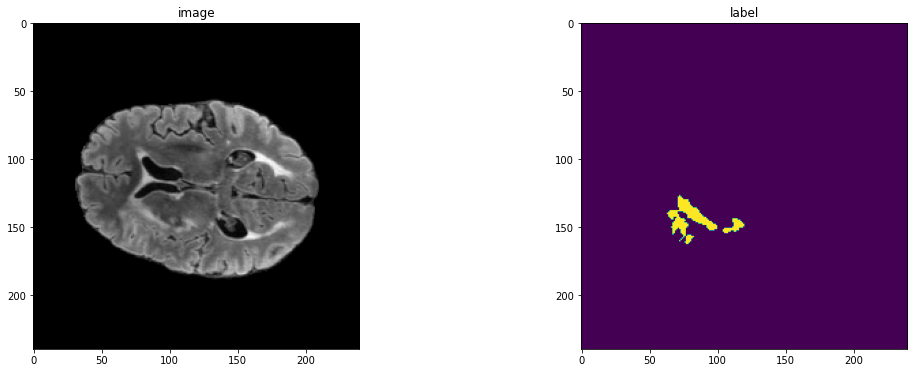

In [12]:
img_add = os.path.join(
    data_dir, "BraTS2021_00621/BraTS2021_00621_flair.nii"
#     kaggle datasets download -d bnyaminbingl/brats2021-training-data-son
#     data_dir, "BraTS2021_00621/BraTS2021_00621_flair.nii"
#     data_dir, "TrainingData/BraTS2021_00006/BraTS2021_00006_flair.nii.gz"
#     data_dir, "HGG_sub/Brats18_CBICA_AUQ_1/Brats18_CBICA_AUQ_1_flair.nii.gz"
)
label_add = os.path.join(
#     data_dir, "TrainingData/BraTS2021_00006/BraTS2021_00006_seg.nii.gz"
    data_dir, "BraTS2021_00621/BraTS2021_00621_seg.nii"
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(img.shape, label.shape)

print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()

## Create Swin UNETR model

In this scetion, we create Swin UNETR model for the 3-class brain tumor semantic segmentation. We use a feature size of 48. We also use gradient checkpointing (use_checkpoint) for more memory-efficient training. However, use_checkpoint for faster training if enough GPU memory is available.  

In [13]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cud" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=12,
#     feature_size=16,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

In [14]:
# !pip install torch-summary
# from torchsummary import summary
# summary(model, (2, 3, 128, 128, 128), device='cpu', verbose=0)
# model

## Optimizer and loss function

In [15]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(
    include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True
)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

## Define Train and Validation Epoch

In [16]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(
                device
            )
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [
                post_pred(post_sigmoid(val_pred_tensor))
                for val_pred_tensor in val_outputs_list
            ]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            Dice_TC = run_acc.avg[0]
            Dice_WT = run_acc.avg[1]
            Dice_ET = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", Dice_TC:",
                Dice_TC,
                ", Dice_WT:",
                Dice_WT,
                ", Dice_ET:",
                Dice_ET,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

## Define Trainer

In [17]:
from itertools import islice as take
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):

    val_acc_max = 0.0
    Dices_TC = []
    Dices_WT = []
    Dices_ET = []
    Dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            Dice_TC = val_acc[0]
            Dice_WT = val_acc[1]
            Dice_ET = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", Dice_TC:",
                Dice_TC,
                ", Dice_WT:",
                Dice_WT,
                ", Dice_ET:",
                Dice_ET,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            Dices_TC.append(Dice_TC)
            Dices_WT.append(Dice_WT)
            Dices_ET.append(Dice_ET)
            Dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        Dices_TC,
        Dices_WT,
        Dices_ET,
        Dices_avg,
        loss_epochs,
        trains_epoch,
    )

## Execute training

In [20]:
start_epoch = 0

# model = model.to('cuda')

(
    val_acc_max,
    Dices_TC,
    Dices_WT,
    Dices_ET,
    Dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Thu Jul  4 10:32:50 2024 Epoch: 0
Epoch 0/10 0/100 loss: 0.9524 time 3.42s
Epoch 0/10 1/100 loss: 0.9707 time 0.90s
Epoch 0/10 2/100 loss: 0.9431 time 0.98s
Epoch 0/10 3/100 loss: 0.9370 time 0.87s
Epoch 0/10 4/100 loss: 0.9479 time 0.87s
Epoch 0/10 5/100 loss: 0.9361 time 0.88s
Epoch 0/10 6/100 loss: 0.9348 time 0.87s
Epoch 0/10 7/100 loss: 0.9343 time 0.87s
Epoch 0/10 8/100 loss: 0.9254 time 0.88s
Epoch 0/10 9/100 loss: 0.9228 time 0.87s
Epoch 0/10 10/100 loss: 0.9262 time 0.87s
Epoch 0/10 11/100 loss: 0.9292 time 0.87s
Epoch 0/10 12/100 loss: 0.9337 time 0.87s
Epoch 0/10 13/100 loss: 0.9368 time 0.87s
Epoch 0/10 14/100 loss: 0.9404 time 0.87s
Epoch 0/10 15/100 loss: 0.9395 time 0.87s
Epoch 0/10 16/100 loss: 0.9393 time 0.87s
Epoch 0/10 17/100 loss: 0.9401 time 0.87s
Epoch 0/10 18/100 loss: 0.9410 time 0.87s
Epoch 0/10 19/100 loss: 0.9420 time 0.88s
Epoch 0/10 20/100 loss: 0.9445 time 0.87s
Epoch 0/10 21/100 loss: 0.9465 time 0.87s
Epoch 0/10 22/100 loss: 0.9488 time 0.87s
Epoch 0/10

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Val 0/10 0/25 , Dice_TC: 0.032710038 , Dice_WT: 0.33495712 , Dice_ET: 0.17726547 , time 8.22s
Val 0/10 1/25 , Dice_TC: 0.062940404 , Dice_WT: 0.3066097 , Dice_ET: 0.0903975 , time 4.00s
Val 0/10 2/25 , Dice_TC: 0.051602706 , Dice_WT: 0.25483587 , Dice_ET: 0.08654406 , time 4.00s
Val 0/10 3/25 , Dice_TC: 0.042274524 , Dice_WT: 0.2525981 , Dice_ET: 0.07859961 , time 4.00s
Val 0/10 4/25 , Dice_TC: 0.03383278 , Dice_WT: 0.20454213 , Dice_ET: 0.0629853 , time 4.00s
Val 0/10 5/25 , Dice_TC: 0.033912215 , Dice_WT: 0.2388509 , Dice_ET: 0.0619216 , time 4.00s
Val 0/10 6/25 , Dice_TC: 0.03233117 , Dice_WT: 0.23402967 , Dice_ET: 0.059040748 , time 3.99s
Val 0/10 7/25 , Dice_TC: 0.03042185 , Dice_WT: 0.24056217 , Dice_ET: 0.05504385 , time 3.99s
Val 0/10 8/25 , Dice_TC: 0.042864457 , Dice_WT: 0.25150093 , Dice_ET: 0.06947582 , time 3.99s
Val 0/10 9/25 , Dice_TC: 0.038767673 , Dice_WT: 0.22972107 , Dice_ET: 0.06370855 , time 4.00s
Val 0/10 10/25 , Dice_TC: 0.036982227 , Dice_WT: 0.22955051 , Dice_E

In [ ]:

# !cp -r /tmp/tmpaw5e_03b/model.pt /kaggle/working
# 
# state_dict = model.state_dict()
# save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
# filename = os.path.join(dir_add, filename)
# torch.save(model.state_dict(), "/kaggle/working/model.pt")


# x, y = next(iter(train_loader))
# print(f'x shape={x.shape} dtype={x.dtype}')
# print(f'y shape={y.shape} dtype={y.dtype}')

# a,b = take(train_loader,None)
# print(a,b )/kaggle/working/tmp/tmpaw5e_03b/model.pt

In [21]:
print(f"train completed, best average dice: {val_acc_max:.4f} ")

train completed, best average dice: 0.2017 


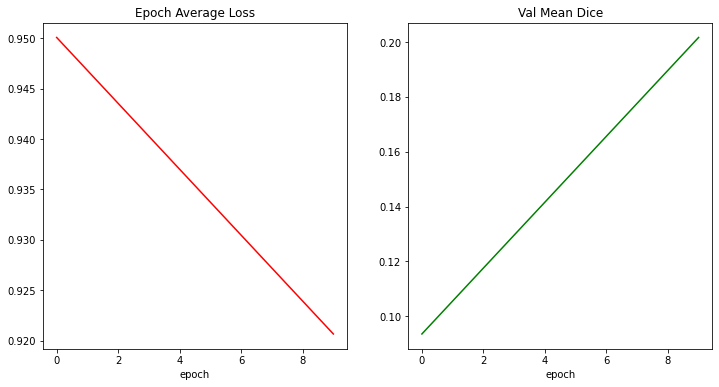

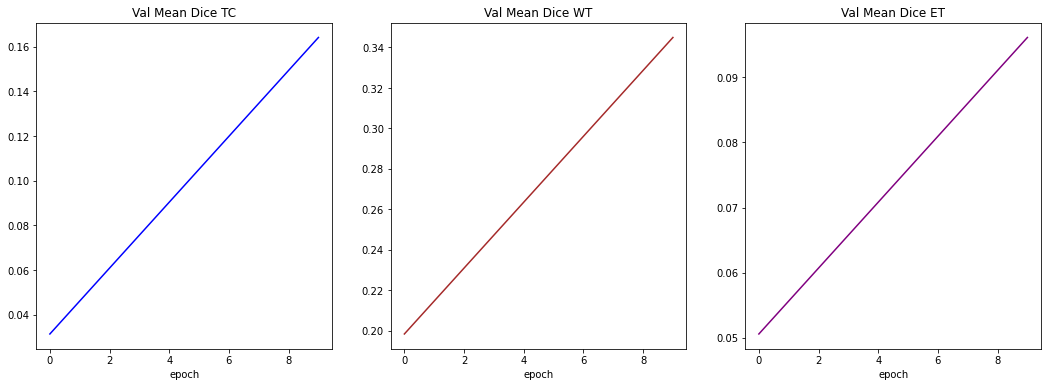

In [22]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, Dices_avg, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, Dices_TC, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, Dices_WT, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, Dices_ET, color="purple")
plt.show()

In [27]:
case_num = "01619"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "BraTS2021_"
                + case_num
                + "/BraTS2021_"
                + case_num
                + "_flair.nii",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_"
                + case_num
                + "/BraTS2021_"
                + case_num
                + "_flair.nii",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_"
                + case_num
                + "/BraTS2021_"
                + case_num
                + "_flair.nii",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_"
                + case_num
                + "/BraTS2021_"
                + case_num
                + "_flair.nii",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "BraTS2021_"
            + case_num
            + "/BraTS2021_"
            + case_num
            + "_seg.nii",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

In [29]:
model.load_state_dict(torch.load(os.path.join("/kaggle/input/dataSwinUnet", "model.pt"))["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for idx, batch_data in enumerate(test_loader):
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

RuntimeError: Error(s) in loading state_dict for SwinUNETR:
	size mismatch for swinViT.patch_embed.proj.weight: copying a param with shape torch.Size([48, 4, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([12, 4, 2, 2, 2]).
	size mismatch for swinViT.patch_embed.proj.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.blocks.0.norm1.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.blocks.0.norm1.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([144, 48]) from checkpoint, the shape in current model is torch.Size([36, 12]).
	size mismatch for swinViT.layers1.0.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([36]).
	size mismatch for swinViT.layers1.0.blocks.0.attn.proj.weight: copying a param with shape torch.Size([48, 48]) from checkpoint, the shape in current model is torch.Size([12, 12]).
	size mismatch for swinViT.layers1.0.blocks.0.attn.proj.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.blocks.0.norm2.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.blocks.0.norm2.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.blocks.0.mlp.linear1.weight: copying a param with shape torch.Size([192, 48]) from checkpoint, the shape in current model is torch.Size([48, 12]).
	size mismatch for swinViT.layers1.0.blocks.0.mlp.linear1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers1.0.blocks.0.mlp.linear2.weight: copying a param with shape torch.Size([48, 192]) from checkpoint, the shape in current model is torch.Size([12, 48]).
	size mismatch for swinViT.layers1.0.blocks.0.mlp.linear2.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.blocks.1.norm1.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.blocks.1.norm1.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([144, 48]) from checkpoint, the shape in current model is torch.Size([36, 12]).
	size mismatch for swinViT.layers1.0.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([36]).
	size mismatch for swinViT.layers1.0.blocks.1.attn.proj.weight: copying a param with shape torch.Size([48, 48]) from checkpoint, the shape in current model is torch.Size([12, 12]).
	size mismatch for swinViT.layers1.0.blocks.1.attn.proj.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.blocks.1.norm2.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.blocks.1.norm2.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.blocks.1.mlp.linear1.weight: copying a param with shape torch.Size([192, 48]) from checkpoint, the shape in current model is torch.Size([48, 12]).
	size mismatch for swinViT.layers1.0.blocks.1.mlp.linear1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers1.0.blocks.1.mlp.linear2.weight: copying a param with shape torch.Size([48, 192]) from checkpoint, the shape in current model is torch.Size([12, 48]).
	size mismatch for swinViT.layers1.0.blocks.1.mlp.linear2.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for swinViT.layers1.0.downsample.reduction.weight: copying a param with shape torch.Size([96, 384]) from checkpoint, the shape in current model is torch.Size([24, 96]).
	size mismatch for swinViT.layers1.0.downsample.norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers1.0.downsample.norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers2.0.blocks.0.norm1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for swinViT.layers2.0.blocks.0.norm1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for swinViT.layers2.0.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([288, 96]) from checkpoint, the shape in current model is torch.Size([72, 24]).
	size mismatch for swinViT.layers2.0.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for swinViT.layers2.0.blocks.0.attn.proj.weight: copying a param with shape torch.Size([96, 96]) from checkpoint, the shape in current model is torch.Size([24, 24]).
	size mismatch for swinViT.layers2.0.blocks.0.attn.proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for swinViT.layers2.0.blocks.0.norm2.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for swinViT.layers2.0.blocks.0.norm2.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for swinViT.layers2.0.blocks.0.mlp.linear1.weight: copying a param with shape torch.Size([384, 96]) from checkpoint, the shape in current model is torch.Size([96, 24]).
	size mismatch for swinViT.layers2.0.blocks.0.mlp.linear1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers2.0.blocks.0.mlp.linear2.weight: copying a param with shape torch.Size([96, 384]) from checkpoint, the shape in current model is torch.Size([24, 96]).
	size mismatch for swinViT.layers2.0.blocks.0.mlp.linear2.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for swinViT.layers2.0.blocks.1.norm1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for swinViT.layers2.0.blocks.1.norm1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for swinViT.layers2.0.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([288, 96]) from checkpoint, the shape in current model is torch.Size([72, 24]).
	size mismatch for swinViT.layers2.0.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([72]).
	size mismatch for swinViT.layers2.0.blocks.1.attn.proj.weight: copying a param with shape torch.Size([96, 96]) from checkpoint, the shape in current model is torch.Size([24, 24]).
	size mismatch for swinViT.layers2.0.blocks.1.attn.proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for swinViT.layers2.0.blocks.1.norm2.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for swinViT.layers2.0.blocks.1.norm2.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for swinViT.layers2.0.blocks.1.mlp.linear1.weight: copying a param with shape torch.Size([384, 96]) from checkpoint, the shape in current model is torch.Size([96, 24]).
	size mismatch for swinViT.layers2.0.blocks.1.mlp.linear1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers2.0.blocks.1.mlp.linear2.weight: copying a param with shape torch.Size([96, 384]) from checkpoint, the shape in current model is torch.Size([24, 96]).
	size mismatch for swinViT.layers2.0.blocks.1.mlp.linear2.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for swinViT.layers2.0.downsample.reduction.weight: copying a param with shape torch.Size([192, 768]) from checkpoint, the shape in current model is torch.Size([48, 192]).
	size mismatch for swinViT.layers2.0.downsample.norm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for swinViT.layers2.0.downsample.norm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for swinViT.layers3.0.blocks.0.norm1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers3.0.blocks.0.norm1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers3.0.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([576, 192]) from checkpoint, the shape in current model is torch.Size([144, 48]).
	size mismatch for swinViT.layers3.0.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for swinViT.layers3.0.blocks.0.attn.proj.weight: copying a param with shape torch.Size([192, 192]) from checkpoint, the shape in current model is torch.Size([48, 48]).
	size mismatch for swinViT.layers3.0.blocks.0.attn.proj.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers3.0.blocks.0.norm2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers3.0.blocks.0.norm2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers3.0.blocks.0.mlp.linear1.weight: copying a param with shape torch.Size([768, 192]) from checkpoint, the shape in current model is torch.Size([192, 48]).
	size mismatch for swinViT.layers3.0.blocks.0.mlp.linear1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for swinViT.layers3.0.blocks.0.mlp.linear2.weight: copying a param with shape torch.Size([192, 768]) from checkpoint, the shape in current model is torch.Size([48, 192]).
	size mismatch for swinViT.layers3.0.blocks.0.mlp.linear2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers3.0.blocks.1.norm1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers3.0.blocks.1.norm1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers3.0.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([576, 192]) from checkpoint, the shape in current model is torch.Size([144, 48]).
	size mismatch for swinViT.layers3.0.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for swinViT.layers3.0.blocks.1.attn.proj.weight: copying a param with shape torch.Size([192, 192]) from checkpoint, the shape in current model is torch.Size([48, 48]).
	size mismatch for swinViT.layers3.0.blocks.1.attn.proj.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers3.0.blocks.1.norm2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers3.0.blocks.1.norm2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers3.0.blocks.1.mlp.linear1.weight: copying a param with shape torch.Size([768, 192]) from checkpoint, the shape in current model is torch.Size([192, 48]).
	size mismatch for swinViT.layers3.0.blocks.1.mlp.linear1.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for swinViT.layers3.0.blocks.1.mlp.linear2.weight: copying a param with shape torch.Size([192, 768]) from checkpoint, the shape in current model is torch.Size([48, 192]).
	size mismatch for swinViT.layers3.0.blocks.1.mlp.linear2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for swinViT.layers3.0.downsample.reduction.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([96, 384]).
	size mismatch for swinViT.layers3.0.downsample.norm.weight: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for swinViT.layers3.0.downsample.norm.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for swinViT.layers4.0.blocks.0.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers4.0.blocks.0.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers4.0.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([288, 96]).
	size mismatch for swinViT.layers4.0.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for swinViT.layers4.0.blocks.0.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for swinViT.layers4.0.blocks.0.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers4.0.blocks.0.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers4.0.blocks.0.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers4.0.blocks.0.mlp.linear1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([384, 96]).
	size mismatch for swinViT.layers4.0.blocks.0.mlp.linear1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for swinViT.layers4.0.blocks.0.mlp.linear2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([96, 384]).
	size mismatch for swinViT.layers4.0.blocks.0.mlp.linear2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers4.0.blocks.1.norm1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers4.0.blocks.1.norm1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers4.0.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([288, 96]).
	size mismatch for swinViT.layers4.0.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for swinViT.layers4.0.blocks.1.attn.proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for swinViT.layers4.0.blocks.1.attn.proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers4.0.blocks.1.norm2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers4.0.blocks.1.norm2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers4.0.blocks.1.mlp.linear1.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([384, 96]).
	size mismatch for swinViT.layers4.0.blocks.1.mlp.linear1.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for swinViT.layers4.0.blocks.1.mlp.linear2.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([96, 384]).
	size mismatch for swinViT.layers4.0.blocks.1.mlp.linear2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for swinViT.layers4.0.downsample.reduction.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([192, 768]).
	size mismatch for swinViT.layers4.0.downsample.norm.weight: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for swinViT.layers4.0.downsample.norm.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for encoder1.layer.conv1.conv.weight: copying a param with shape torch.Size([48, 4, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([12, 4, 3, 3, 3]).
	size mismatch for encoder1.layer.conv2.conv.weight: copying a param with shape torch.Size([48, 48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([12, 12, 3, 3, 3]).
	size mismatch for encoder1.layer.conv3.conv.weight: copying a param with shape torch.Size([48, 4, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([12, 4, 1, 1, 1]).
	size mismatch for encoder2.layer.conv1.conv.weight: copying a param with shape torch.Size([48, 48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([12, 12, 3, 3, 3]).
	size mismatch for encoder2.layer.conv2.conv.weight: copying a param with shape torch.Size([48, 48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([12, 12, 3, 3, 3]).
	size mismatch for encoder3.layer.conv1.conv.weight: copying a param with shape torch.Size([96, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([24, 24, 3, 3, 3]).
	size mismatch for encoder3.layer.conv2.conv.weight: copying a param with shape torch.Size([96, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([24, 24, 3, 3, 3]).
	size mismatch for encoder4.layer.conv1.conv.weight: copying a param with shape torch.Size([192, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([48, 48, 3, 3, 3]).
	size mismatch for encoder4.layer.conv2.conv.weight: copying a param with shape torch.Size([192, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([48, 48, 3, 3, 3]).
	size mismatch for encoder10.layer.conv1.conv.weight: copying a param with shape torch.Size([768, 768, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([192, 192, 3, 3, 3]).
	size mismatch for encoder10.layer.conv2.conv.weight: copying a param with shape torch.Size([768, 768, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([192, 192, 3, 3, 3]).
	size mismatch for decoder5.transp_conv.conv.weight: copying a param with shape torch.Size([768, 384, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([192, 96, 2, 2, 2]).
	size mismatch for decoder5.conv_block.conv1.conv.weight: copying a param with shape torch.Size([384, 768, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 192, 3, 3, 3]).
	size mismatch for decoder5.conv_block.conv2.conv.weight: copying a param with shape torch.Size([384, 384, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 96, 3, 3, 3]).
	size mismatch for decoder5.conv_block.conv3.conv.weight: copying a param with shape torch.Size([384, 768, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 192, 1, 1, 1]).
	size mismatch for decoder4.transp_conv.conv.weight: copying a param with shape torch.Size([384, 192, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([96, 48, 2, 2, 2]).
	size mismatch for decoder4.conv_block.conv1.conv.weight: copying a param with shape torch.Size([192, 384, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([48, 96, 3, 3, 3]).
	size mismatch for decoder4.conv_block.conv2.conv.weight: copying a param with shape torch.Size([192, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([48, 48, 3, 3, 3]).
	size mismatch for decoder4.conv_block.conv3.conv.weight: copying a param with shape torch.Size([192, 384, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 96, 1, 1, 1]).
	size mismatch for decoder3.transp_conv.conv.weight: copying a param with shape torch.Size([192, 96, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([48, 24, 2, 2, 2]).
	size mismatch for decoder3.conv_block.conv1.conv.weight: copying a param with shape torch.Size([96, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([24, 48, 3, 3, 3]).
	size mismatch for decoder3.conv_block.conv2.conv.weight: copying a param with shape torch.Size([96, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([24, 24, 3, 3, 3]).
	size mismatch for decoder3.conv_block.conv3.conv.weight: copying a param with shape torch.Size([96, 192, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 48, 1, 1, 1]).
	size mismatch for decoder2.transp_conv.conv.weight: copying a param with shape torch.Size([96, 48, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([24, 12, 2, 2, 2]).
	size mismatch for decoder2.conv_block.conv1.conv.weight: copying a param with shape torch.Size([48, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([12, 24, 3, 3, 3]).
	size mismatch for decoder2.conv_block.conv2.conv.weight: copying a param with shape torch.Size([48, 48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([12, 12, 3, 3, 3]).
	size mismatch for decoder2.conv_block.conv3.conv.weight: copying a param with shape torch.Size([48, 96, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([12, 24, 1, 1, 1]).
	size mismatch for decoder1.transp_conv.conv.weight: copying a param with shape torch.Size([48, 48, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([12, 12, 2, 2, 2]).
	size mismatch for decoder1.conv_block.conv1.conv.weight: copying a param with shape torch.Size([48, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([12, 24, 3, 3, 3]).
	size mismatch for decoder1.conv_block.conv2.conv.weight: copying a param with shape torch.Size([48, 48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([12, 12, 3, 3, 3]).
	size mismatch for decoder1.conv_block.conv3.conv.weight: copying a param with shape torch.Size([48, 96, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([12, 24, 1, 1, 1]).
	size mismatch for out.conv.conv.weight: copying a param with shape torch.Size([3, 48, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 12, 1, 1, 1]).

NameError: name 'seg_out' is not defined

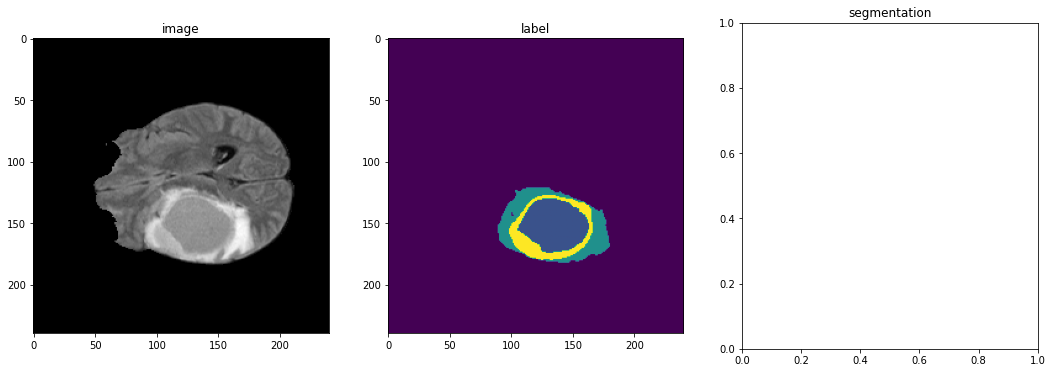

In [30]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii",
)
label_add = os.path.join(
    data_dir,
    "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

In [26]:
if directory is None:
    shutil.rmtree(root_dir)